# **Naive Bayes Classification with Smoothing from Scratch**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # enhanced visualization
from sklearn.datasets import load_breast_cancer # dataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

# Import the normal (Gaussian) distribution functions from SciPy
from scipy.stats import norm
# Import base classes to create custom models following scikit-learn's API
from sklearn.base import BaseEstimator, ClassifierMixin

In [11]:
data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Naive Bayes Class**

In [ ]:
# Define a custom Naive Bayes Classifier by inheriting from BaseEstimator and ClassifierMixin
class NaiveBayes(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        # Identify the unique classes in the labels
        self.classes = np.unique(y)
        
        # Initialize dictionaries to store class-wise statistics
        self.means = {}
        self.stds = {}
        self.priors = {}

        # For each class, calculate the mean, standard deviation, and prior probability
        for c in self.classes:
            X_c = X[y == c]  # Select samples belonging to class c
            self.means[c] = X_c.mean(axis=0)  # Mean for each feature
            self.stds[c] = X_c.std(axis=0) + 1e-6  # Standard deviation (add small value to prevent division by zero //// smoothing) 
            self.priors[c] = len(X_c) / len(X)  # Prior = (# samples of class c) / (total samples)

        return self  # Always return self in scikit-learn custom models for method chaining

    def predict_proba(self, X):
        # Initialize an array to store probabilities for each class
        probs = np.zeros((X.shape[0], len(self.classes)))

        for c in self.classes:
            # Compute the likelihood assuming Gaussian distribution for each feature
            likelihood = norm(self.means[c], self.stds[c]).pdf(X).prod(axis=1)
            # Multiply by prior probability to get unnormalized posterior
            probs[:, c] = likelihood * self.priors[c]

        return probs  # Return probability estimates for each classa

    def predict(self, X):
        # Predict the class with the highest probability
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)  # Choose the class with maximum probability


In [13]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

# Predictions
y_pred = nb.predict(X_test)
y_proba = nb.predict_proba(X_test)[:, 1]

**Performance Metrics**

In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9649122807017544
Precision: 0.958904109589041
Recall: 0.9859154929577465
F1 Score: 0.9722222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



**Confusion Matrix**

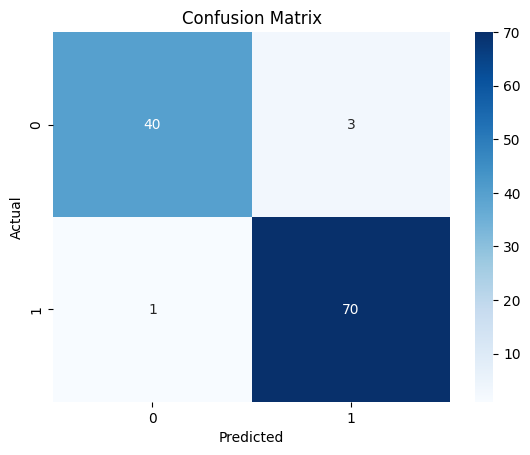

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# confusion matrix shows that the model correctly predicted most cases, with 40 true negatives, 70 true positives, 3 false positives, and 1 false negative

**ROC curve**

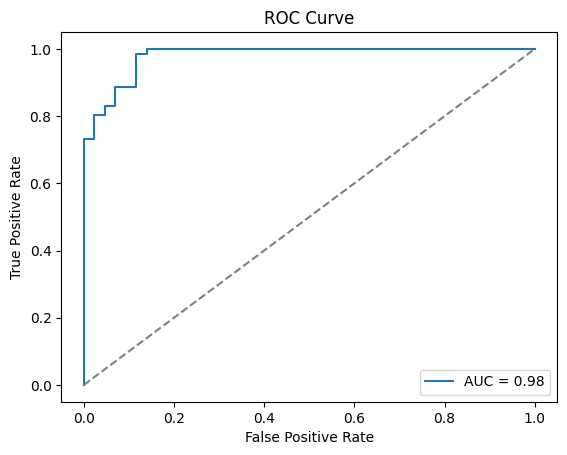

In [ ]:
# Receiver Operating Characteristic (ROC)
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')  # AUC value (between 0 and 1; closer to 1 means excellent classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ROC curve plots the True Positive Rate against the False Positive Rate at various thresholds to evaluate a model’s classification performance.

**Precision-Recall Curve**

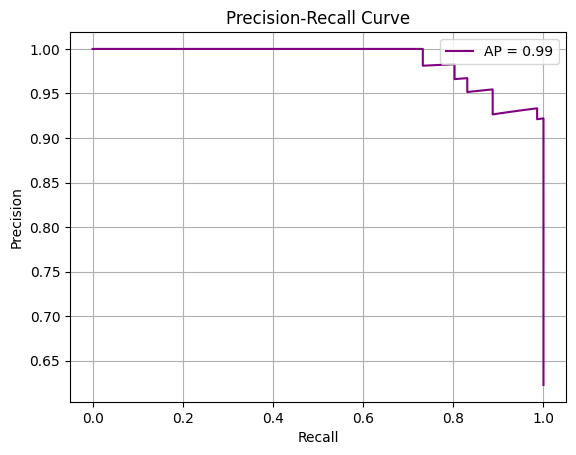

In [17]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

**Cross Validation**

In [18]:
cv_scores = cross_val_score(nb, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.87719298 0.92982456 0.94736842 0.97368421 0.92035398]
Mean CV Accuracy: 0.9297
